# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


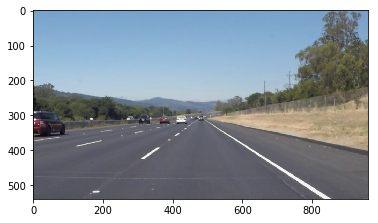

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            print(x1,y1,x2,y2)# my modification
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [4]:
def average_lines(lines, img):
    '''
    img should be a regioned canny output
    '''
    if lines is None: return lines
    
    positive_slopes = []
    positive_xs = []
    positive_ys = []
    negative_slopes = []
    negative_xs = []
    negative_ys = []
    
    min_slope = .3
    max_slope = 1000
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)
            
            if abs(slope) < min_slope or abs(slope) > max_slope: continue  # Filter our slopes
                
            # We only need one point sample and the slope to determine the line equation
            positive_slopes.append(slope) if slope > 0 else negative_slopes.append(slope)
            positive_xs.append(x1) if slope > 0 else negative_xs.append(x1)
            positive_ys.append(y1) if slope > 0 else negative_ys.append(y1)
    
    # We need to calculate our region_top_y from the canny image so we know where to extend our lines to
    ysize, xsize = img.shape[0], img.shape[1]
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    white = img == 255
    YY[~white] = ysize*2  # Large number because we will take the min
    
    region_top_y = np.amin(YY)
    
    new_lines = []
    if len(positive_slopes) > 0:
        m = np.mean(positive_slopes)
        avg_x = np.mean(positive_xs)
        avg_y = np.mean(positive_ys)
        
        b = avg_y - m*avg_x
        
        # We have m and b, so with a y we can get x = (y-b)/m
        x1 = int((region_top_y - b)/m)
        x2 = int((ysize - b)/m)
        
        new_lines.append([(x1, region_top_y, x2, ysize)])
    
    if len(negative_slopes) > 0:
        m = np.mean(negative_slopes)
        avg_x = np.mean(negative_xs)
        avg_y = np.mean(negative_ys)
        
        b = avg_y - m*avg_x
        
        # We have m and b, so with a y we can get x = (y-b)/m
        x1 = int((region_top_y - b)/m)
        x2 = int((ysize - b)/m)
        
        new_lines.append([(x1, region_top_y, x2, ysize)])
            
    return np.array(new_lines)

def avg_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    avg_lines = average_lines(lines, img)
    #draw_lines(line_img, lines)
    draw_lines(line_img, avg_lines)
    return line_img

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

In [7]:
# To apply Canny Edged it is necessary to use the image on grayscale:
imageGray = grayscale(image)

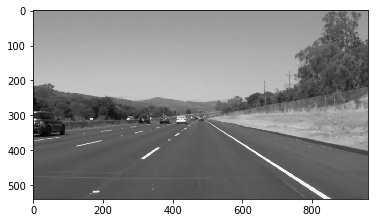

In [8]:
plt.imshow(imageGray, cmap='gray')

In [9]:
# Using Gaussian blur to "smooth" the image:
kernel_size = 5
blur_gray = gaussian_blur(imageGray, kernel_size)

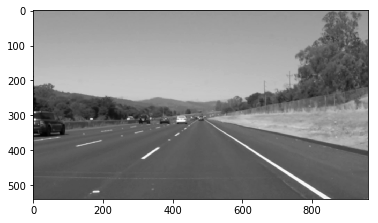

In [10]:
plt.imshow(blur_gray, cmap='gray')

In [11]:
# Defining the Canny function thresholds:
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)

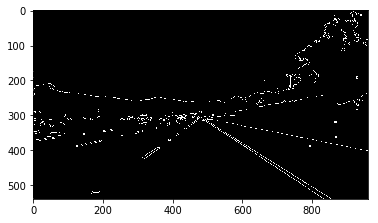

In [12]:
# Display the image:
plt.imshow(edges, cmap='Greys_r')

In [13]:
#Defining the area (mask) that is used to apply the functions:
imshape = image.shape
vertices = np.array([[(.03*imshape[1],imshape[0]),
                       (0.48*imshape[1], 0.60*imshape[0]),
                       (0.52*imshape[1], 0.60*imshape[0]), 
                       (.95*imshape[1],imshape[0])]], dtype=np.int32)

# vertices = np.array([[(0+30,imshape[0]),
#                       (imshape[1]/2-20,imshape[0]/2+20),
#                       (imshape[1]/2+20, imshape[0]/2+20), 
#                       (imshape[1]-30,imshape[0])]], dtype=np.int32)

#vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)

In [14]:
# Applying the mask to the image:
maskedEdges = region_of_interest(edges, vertices)

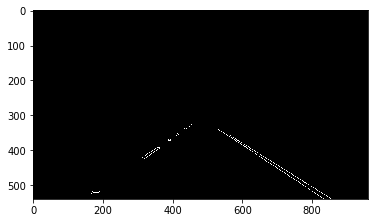

In [15]:
plt.imshow(maskedEdges, cmap='Greys_r')

In [16]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 10     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 30  #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

In [17]:
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
#`img` should be the output of a Canny transform.
lines = avg_hough_lines(maskedEdges, rho, theta, threshold, min_line_len, max_line_gap)

508 326 849 540
454 326 143 540


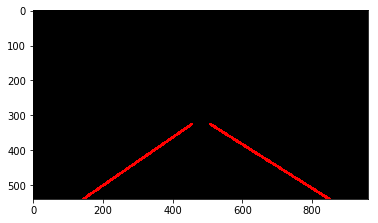

In [18]:
plt.imshow(lines)

In [19]:
final = weighted_img(lines, image, α=0.8, β=1., γ=0.)

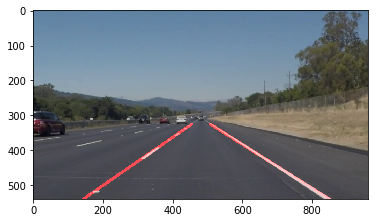

In [20]:
plt.imshow(final)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    imageGray = grayscale(image)

    kernel_size = 5
    blur_gray = gaussian_blur(imageGray, kernel_size)

    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    imshape = image.shape
    vertices = np.array([[(.03*imshape[1],imshape[0]),
                           (0.48*imshape[1], 0.60*imshape[0]),
                           (0.52*imshape[1], 0.60*imshape[0]), 
                           (.95*imshape[1],imshape[0])]], dtype=np.int32)

    maskedEdges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 30  #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    #`img` should be the output of a Canny transform.
    lines = avg_hough_lines(maskedEdges, rho, theta, threshold, min_line_len, max_line_gap)

    final = weighted_img(lines, image, α=0.8, β=1., γ=0.)
      
    return final

In [23]:
# def process_image(image):
#     # NOTE: The output you return should be a color image (3 channel) for processing video below
#     # TODO: put your pipeline here,
#     # you should return the final output (image where lines are drawn on lanes)

#     return result

Let's try the one with the solid white lane on the right first ...

In [24]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

523 331 858 540
446 331 152 540
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|▏         | 3/222 [00:00<00:09, 24.09it/s]

523 331 858 540
446 331 152 540
524 332 858 540
441 332 158 540
516 332 863 540
439 332 159 540
509 328 859 540
445 328 156 540
523 333 861 540
440 333 151 540
531

  4%|▍         | 9/222 [00:00<00:08, 25.63it/s]

 333 860 540
439 333 152 540
525 334 861 540
439 334 145 540
531 335 866 540
435 335 156 540
518 329 863 540
445 329 148 540
508 327 864 540
447 327 160 540
501 324 851 540
453 324 162 540


  7%|▋         | 15/222 [00:00<00:07, 26.15it/s]

509 324 848 540
462 324 149 540
509 324 845 540
456 324 152 540
515 332 844 540
439 332 154 540
523 332 848 540
436 332 152 540
532 340 849 540
430 340 144 540
536 341 844 540
426 341 134 540


  9%|▉         | 21/222 [00:00<00:07, 25.66it/s]

523 334 853 540
436 334 133 540
528 334 837 540
440 334 136 540
512 329 844 540
443 329 161 540
506 326 843 540
454 326 150 540
506 326 844 540
452 326 150 540


 12%|█▏        | 27/222 [00:01<00:07, 26.17it/s]

512 326 848 540
451 326 159 540
519 331 844 540
446 331 150 540
518 331 846 540
442 331 152 540
523 332 847 540
437 332 156 540
517 332 854 540
448 332 144 540
524 333 838 540
437 333 157 540


 15%|█▍        | 33/222 [00:01<00:07, 26.64it/s]

528 333 850 540
442 333 151 540
518 333 846 540
440 333 155 540
524 334 848 540
439 334 158 540
529 335 852 540
437 335 151 540
528 335 850 540
440 335 140 540
525 336 846 540
437 336 148 540


 18%|█▊        | 39/222 [00:01<00:06, 26.81it/s]

516 330 847 540
444 330 158 540
518 331 847 540
439 331 163 540
513 331 844 540
445 331 154 540
518 332 842 540
438 332 161 540
515 332 855 540
443 332 151 540
523 332 838 540
438 332 155 540


 19%|█▉        | 42/222 [00:01<00:06, 26.86it/s]

518 333 843 540
437 333 156 540
527 334 835 540
435 334 157 540
523 334 846 540
435 334 157 540


 20%|██        | 45/222 [00:01<00:10, 16.23it/s]

543 345 847 540
420 345 147 540
521 335 842 540
440 335 138 540
527 336 846 540
438 336 136 540


 22%|██▏       | 48/222 [00:02<00:11, 14.70it/s]

529 336 850 540
431 336 151 540
536 337 843 540
425 337 154 540
535 338 847 540
434 338 144 540


 23%|██▎       | 52/222 [00:02<00:13, 13.06it/s]

539 339 848 540
433 339 139 540
536 340 850 540
429 340 145 540
537 341 843 540
425 341 142 540


 24%|██▍       | 54/222 [00:02<00:13, 12.80it/s]

537 341 845 540
419 341 140 540
528 335 854 540
435 335 132 540
528 335 845 540
438 335 124 540


 26%|██▌       | 58/222 [00:03<00:13, 12.57it/s]

527 335 846 540
436 335 135 540
513 331 843 540
443 331 137 540
513 330 843 540
446 330 132 540


 27%|██▋       | 60/222 [00:03<00:13, 12.39it/s]

511 331 843 540
444 331 136 540
518 331 837 540
443 331 138 540
518 328 837 540
450 328 133 540


 29%|██▉       | 64/222 [00:03<00:13, 11.94it/s]

517 328 833 540
445 328 138 540
522 330 826 540
446 330 135 540
513 329 842 540
447 329 135 540


 30%|██▉       | 66/222 [00:03<00:12, 12.09it/s]

515 329 837 540
446 329 131 540
516 330 842 540
444 330 139 540
517 333 838 540
441 333 118 540


 31%|███       | 68/222 [00:03<00:12, 12.15it/s]

526 334 838 540
436 334 125 540
523 333 835 540
436 333 132 540
522 332 836 540
434 332 140 540


 32%|███▏      | 72/222 [00:04<00:12, 12.47it/s]

522 334 834 540
435 334 136 540
525 334 834 540
437 334 125 540
520 333 831 540
438 333 129 540


 34%|███▍      | 76/222 [00:04<00:11, 12.26it/s]

523 332 836 540
444 332 127 540
522 332 833 540
432 332 138 540
521 333 833 540
438 333 128 540


 35%|███▌      | 78/222 [00:04<00:11, 12.04it/s]

518 334 838 540
429 334 129 540
517 333 828 540
433 333 127 540
513 333 827 540
437 333 120 540


 37%|███▋      | 82/222 [00:04<00:11, 12.34it/s]

514 333 830 540
444 333 101 540
519 333 829 540
432 333 130 540
524 334 824 540
435 334 119 540


 38%|███▊      | 84/222 [00:05<00:11, 12.43it/s]

523 334 825 540
432 334 125 540
528 335 829 540
436 335 115 540
527 335 823 540
437 335 117 540


 40%|███▉      | 88/222 [00:05<00:10, 12.52it/s]

523 335 833 540
438 335 121 540
528 337 829 540
436 337 119 540
525 335 822 540
434 335 127 540


 41%|████      | 90/222 [00:05<00:10, 12.60it/s]

522 334 824 540
438 334 125 540
525 335 815 540
439 335 111 540
526 335 810 540
435 335 130 540


 42%|████▏     | 94/222 [00:05<00:09, 12.97it/s]

518 330 818 540
444 330 123 540
513 330 822 540
444 330 127 540
516 330 820 540
443 330 129 540


 43%|████▎     | 96/222 [00:06<00:09, 13.01it/s]

528 337 814 540
433 337 128 540
523 333 822 540
436 333 127 540
532 338 823 540
427 338 126 540


 44%|████▍     | 98/222 [00:06<00:09, 12.86it/s]

533 338 820 540
434 338 121 540
536 339 823 540
433 339 118 540


 46%|████▌     | 102/222 [00:06<00:09, 12.05it/s]

533 340 824 540
428 340 122 540
526 332 827 540
444 332 120 540
522 328 819 540
447 328 131 540


 47%|████▋     | 104/222 [00:06<00:10, 11.26it/s]

509 325 822 540
449 325 149 540
509 324 823 540
459 324 132 540
515

 48%|████▊     | 106/222 [00:06<00:09, 11.73it/s]

 325 831 540
453 325 138 540
518 329 836 540
451 329 125 540
520 329 828 540
447 329 134 540


 50%|████▉     | 110/222 [00:07<00:09, 12.18it/s]

525 330 830 540
440 330 145 540
524 330 831 540
450 330 131 540
518 326 830 540
453 326 136 540


 50%|█████     | 112/222 [00:07<00:08, 12.25it/s]

515 324 836 540
456 324 138 540
519 324 831 540
453 324 140 540
523 327 835 540
449 327 141 540


 52%|█████▏    | 116/222 [00:07<00:08, 12.49it/s]

518 324 839 540
454 324 135 540
527 328 837 540
445 328 146 540
530 328 839 540
448 328 135 540


 53%|█████▎    | 118/222 [00:07<00:08, 12.52it/s]

516 325 840 540
453 325 132 540
519 325 838 540
454 325 129 540
516 325 834 540
451 325 137 540


 55%|█████▍    | 122/222 [00:08<00:07, 12.56it/s]

514 324 836 540
454 324 137 540
511 324 846 540
457 324 136 540
510 324 850 540
459 324 136 540


 56%|█████▌    | 124/222 [00:08<00:07, 12.54it/s]

513 324 840 540
452 324 147 540
515 324 842 540
464 324 129 540
515 324 841 540
454 324 141 540


 58%|█████▊    | 128/222 [00:08<00:07, 12.40it/s]

514 324 839 540
459 324 137 540
507 324 843 540
459 324 134 540
511 324 851 540
459 324 143 540


 59%|█████▊    | 130/222 [00:08<00:07, 12.50it/s]

512 324 851 540
458 324 145 540
515 324 852 540
462 324 137 540
510 324 850 540
460 324 148 540


 59%|█████▉    | 132/222 [00:09<00:07, 12.33it/s]

512 324 853 540
456 324 158 540
511 324 856 540
455 324 157 540
508 324 858 540
455 324 156 540


 61%|██████▏   | 136/222 [00:09<00:06, 12.44it/s]

514 325 850 540
453 325 153 540
527 330 857 540
448 330 147 540
528 331 857 540
444 331 148 540


 63%|██████▎   | 140/222 [00:09<00:06, 12.26it/s]

529 331 860 540
441 331 157 540
512 325 864 540
457 325 139 540
514 324 849 540
456 324 154 540


 64%|██████▍   | 142/222 [00:09<00:06, 12.19it/s]

506 324 854 540
460 324 148 540
509 324 849 540
456 324 162 540
511 324 849 540
456 324 164 540


 66%|██████▌   | 146/222 [00:10<00:06, 12.46it/s]

510 324 850 540
458 324 165 540
511 324 849 540
460 324 158 540
518 324 857 540
461 324 156 540


 67%|██████▋   | 148/222 [00:10<00:05, 12.40it/s]

518 324 855 540
459 324 156 540
518 326 859 540
452 326 159 540
518 325 859 540
456 325 157 540


 68%|██████▊   | 152/222 [00:10<00:05, 12.19it/s]

513 324 866 540
456 324 170 540
523 324 864 540
458 324 165 540
507 324 861 540
460 324 156 540


 69%|██████▉   | 154/222 [00:10<00:05, 12.33it/s]

514 324 860 540
460 324 160 540
520 324 861 540
459 324 154 540
516 324 868 540
455 324 167 540


 71%|███████   | 158/222 [00:11<00:05, 12.64it/s]

524 324 862 540
455 324 165 540
519 324 865 540
458 324 157 540
519 324 863 540
455 324 165 540


 72%|███████▏  | 160/222 [00:11<00:04, 12.56it/s]

521 324 864 540
457 324 165 540
518 324 871 540
457 324 167 540
523 324 877 540
453 324 174 540


 74%|███████▍  | 164/222 [00:11<00:04, 12.19it/s]

522 324 873 540
459 324 172 540
520 324 879 540
459 324 175 540
519 324 876 540
459 324 179 540


 75%|███████▍  | 166/222 [00:11<00:04, 12.36it/s]

511 324 877 540
464 324 165 540
511 324 873 540
459 324 181 540
507 324 875 540
464 324 173 540


 77%|███████▋  | 170/222 [00:12<00:04, 12.24it/s]

507 324 873 540
457 324 186 540
512 324 878 540
464 324 176 540
511 324 876 540
457 324 186 540


 77%|███████▋  | 172/222 [00:12<00:04, 11.92it/s]

516 324 879 540
461 324 179 540
514 324 878 540
463 324 177 540
508 324 873 540
459 324 183 540


 79%|███████▉  | 176/222 [00:12<00:03, 12.33it/s]

512 326 875 540
454 326 193 540
512 324 878 540
459 324 180 540
507 324 877 540
458 324 188 540


 80%|████████  | 178/222 [00:12<00:03, 12.26it/s]

509 324 875 540
462 324 179 540
503 324 884 540
459 324 189 540
512 324 878 540
458 324 185 540


 82%|████████▏ | 182/222 [00:13<00:03, 12.25it/s]

512 324 876 540
455 324 191 540
514 324 882 540
458 324 190 540
518 324 879 540
458 324 187 540


 83%|████████▎ | 184/222 [00:13<00:03, 12.21it/s]

512 324 888 540
459 324 192 540
501 324 870 540
455 324 188 540
508 324 881 540
458 324 185 540


 85%|████████▍ | 188/222 [00:13<00:02, 11.91it/s]

509 324 879 540
458 324 183 540
514 324 878 540
458 324 185 540
516 324 884 540
453 324 193 540


 86%|████████▌ | 190/222 [00:13<00:02, 12.03it/s]

536 332 890 540
442 332 188 540
539 332 889 540
441 332 177 540
530 333 894 540
446 333 166 540


 86%|████████▋ | 192/222 [00:13<00:02, 12.32it/s]

510 324 902 540
455 324 180 540
513 324 883 540
456 324 194 540
518 324 888 540
455 324 191 540


 88%|████████▊ | 196/222 [00:14<00:02, 11.98it/s]

513 324 881 540
457 324 189 540
509 324 882 540
459 324 186 540
511 324 877 540
458 324 188 540


 90%|█████████ | 200/222 [00:14<00:01, 12.27it/s]

513 324 876 540
460 324 169 540
515 324 879 540
455 324 188 540
512 324 886 540
457 324 185 540


 91%|█████████ | 202/222 [00:14<00:01, 12.24it/s]

505 324 888 540
457 324 181 540
513 324 889 540
459 324 176 540
505 324 887 540
460 324 171 540


 93%|█████████▎| 206/222 [00:15<00:01, 12.08it/s]

516 324 885 540
460 324 178 540
506 324 895 540
459 324 178 540
508 324 895 540
452 324 184 540


 94%|█████████▎| 208/222 [00:15<00:01, 12.21it/s]

513 324 890 540
454 324 185 540
508 324 895 540
463 324 178 540
513 324 899 540
453 324 185 540


 95%|█████████▌| 212/222 [00:15<00:00, 12.49it/s]

516 324 890 540
453 324 189 540
516 324 891 540
457 324 173 540
510 324 900 540
457 324 184 540


 96%|█████████▋| 214/222 [00:15<00:00, 12.54it/s]

510 324 892 540
459 324 179 540
517 324 888 540
457 324 186 540
509 324 893 540
457 324 184 540


 97%|█████████▋| 216/222 [00:15<00:00, 11.87it/s]

507 324 889 540
460 324 184 540
509 324 891 540
457 324 190 540
505 324 890 540
459 324 186 540


100%|█████████▉| 221/222 [00:16<00:00, 13.54it/s]

507 324 886 540
465 324 180 540
504 324 886 540
461 324 177 540
500 324 886 540
457 324 182 540


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.12 s, sys: 1.76 s, total: 5.88 s
Wall time: 18.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [26]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

513 326 831 540
468 326 99 540
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 3/682 [00:00<00:27, 24.95it/s]

513 326 831 540
468 326 99 540
512 326 830 540
461 326 114 540
513 326 830 540
460 326 114 540
512 326 834 540
455 326 118 540
514 326 835 540
455 326 121 540
512 325 837 540
466 325 122 540


  1%|▏         | 9/682 [00:00<00:25, 26.22it/s]

513 325 847 540
461 325 123 540
518 327 842 540
462 327 122 540
519 327 838 540
463 327 123 540
515 328 859 540
450 328 133 540


  2%|▏         | 12/682 [00:00<00:25, 26.69it/s]

516 328 851 540
461 328 123 540
525 329 842 540
449 329 133 540


  2%|▏         | 15/682 [00:00<00:24, 26.96it/s]

523 329 851 540
452 329 127 540
523 329 843 540
444 329 141 540
517 330 855 540
454 330 137 540
516 330 856 540
448 330 142 540


  3%|▎         | 18/682 [00:00<00:24, 27.17it/s]

518 330 851 540
455 330 136 540
522 330 840 540
450 330 140 540


  3%|▎         | 21/682 [00:00<00:24, 27.20it/s]

521 331 876 540
446 331 144 540
526 332 852 540
440 332 149 540
528 334 863 540
438 334 141 540
535 335 847 540
440 335 137 540


  4%|▎         | 24/682 [00:00<00:24, 27.31it/s]

526 335 864 540
443 335 138 540
527 335 868 540
439 335 137 540


  4%|▍         | 27/682 [00:00<00:23, 27.34it/s]

526 334 859 540
441 334 143 540
528 333 857 540
442 333 149 540
533 334 860 540
440 334 147 540
529 335 861 540
435 335 156 540


  4%|▍         | 30/682 [00:01<00:24, 26.93it/s]

538 335 868 540
443 335 145 540
524 336 867 540
434 336 154 540


  5%|▍         | 33/682 [00:01<00:23, 27.35it/s]

527 336 887 540
449 336 137 540
531 336 874 540
433 336 154 540
534 337 865 540
439 337 144 540
534 337 863 540
431 337 159 540


  5%|▌         | 36/682 [00:01<00:23, 27.64it/s]

539 338 867 540
430 338 158 540
540 339 871 540
429 339 153 540


  6%|▌         | 39/682 [00:01<00:23, 27.73it/s]

544 339 869 540
423 339 165 540
542 340 876 540
429 340 157 540
545 341 875 540
426 341 154 540
543 342 875 540
421 342 146 540


  6%|▌         | 42/682 [00:01<00:23, 27.61it/s]

546 342 873 540
423 342 148 540
537 342 879 540
421 342 151 540
422 342 156 540
536 342 899 540
423 342 152 540


  7%|▋         | 45/682 [00:01<00:37, 16.77it/s]

542 340 850 540
426 340 150 540
534 340 868 540
435 340 151 540
536 339 871 540
427 339 155 540


  7%|▋         | 48/682 [00:02<00:41, 15.11it/s]

538 339 872 540
431 339 154 540
531 340 881 540
436 340 143 540


  7%|▋         | 50/682 [00:02<00:44, 14.26it/s]

543 341 872 540
423 341 150 540


  8%|▊         | 52/682 [00:02<00:46, 13.64it/s]

529 340 880 540
421 340 152 540
536 339 870 540
429 339 152 540
532 338 872 540
432 338 150 540


  8%|▊         | 54/682 [00:02<00:47, 13.09it/s]

533 337 870 540
429 337 153 540
526 337 869 540
427 337 152 540


  8%|▊         | 56/682 [00:02<00:48, 12.79it/s]

524 338 892 540
427 338 149 540


  9%|▊         | 58/682 [00:02<00:49, 12.62it/s]

525 338 887 540
433 338 151 540
530 337 866 540
431 337 154 540
531 338 871 540
434 338 151 540


  9%|▉         | 60/682 [00:03<00:50, 12.32it/s]

530 338 868 540
429 338 146 540
526 338 876 540
428 338 145 540


  9%|▉         | 62/682 [00:03<00:50, 12.29it/s]

531 339 868 540
423 339 143 540


  9%|▉         | 64/682 [00:03<00:50, 12.34it/s]

532 340 867 540
430 340 141 540
533 339 867 540
418 339 151 540
531 337 861 540
427 337 144 540


 10%|▉         | 66/682 [00:03<00:51, 11.94it/s]

525 337 862 540
430 337 141 540
532 336 857 540
437 336 142 540
432 336 145 540


 10%|█         | 70/682 [00:03<00:49, 12.25it/s]

522 335 885 540
435 335 149 540
522 335 867 540
433 335 145 540
525 335 863 540
437 335 143 540


 11%|█         | 72/682 [00:04<00:49, 12.32it/s]

529 335 849 540
433 335 150 540
520 334 863 540
438 334 148 540


 11%|█         | 74/682 [00:04<00:49, 12.21it/s]

518 334 865 540
444 334 142 540


 11%|█         | 76/682 [00:04<00:48, 12.42it/s]

518 334 859 540
433 334 152 540
516 333 854 540
434 333 150 540
518 333 855 540
427 333 160 540


 11%|█▏        | 78/682 [00:04<00:49, 12.09it/s]

526 334 848 540
434 334 147 540
519 334 854 540
433 334 147 540


 12%|█▏        | 80/682 [00:04<00:48, 12.53it/s]

522 334 852 540
434 334 149 540
521 334 863 540
435 334 146 540
530 335 839 540
441 335 139 540


 12%|█▏        | 84/682 [00:05<00:58, 10.20it/s]

521 335 857 540
445 335 132 540
526 336 853 540
427 336 141 540


 13%|█▎        | 86/682 [00:05<01:02,  9.46it/s]

523 335 856 540
435 335 143 540
519 334 860 540
434 334 141 540


 13%|█▎        | 89/682 [00:05<00:58, 10.17it/s]

527 335 851 540
435 335 145 540
522 335 852 540
435 335 140 540
523 335 855 540
437 335 130 540


 13%|█▎        | 91/682 [00:05<00:55, 10.60it/s]

518 334 853 540
437 334 137 540
514 333 856 540
442 333 136 540
510 330 852 540
448 330 140 540


 14%|█▍        | 95/682 [00:06<00:50, 11.64it/s]

510 329 847 540
443 329 140 540
513 328 825 540
452 328 143 540
503 327 860 540
460 327 137 540


 14%|█▍        | 97/682 [00:06<00:49, 11.94it/s]

511 327 835 540
455 327 148 540
509 328 844 540
458 328 147 540
513 330 848 540
453 330 146 540


 15%|█▍        | 101/682 [00:06<00:46, 12.53it/s]

514 330 849 540
446 330 149 540
518 330 839 540
448 330 147 540
506 330 864 540
450 330 147 540


 15%|█▌        | 103/682 [00:06<00:47, 12.11it/s]

512 330 854 540
436 330 155 540
511 330 850 540
452 330 134 540
514 330 851 540
450 330 144 540


 16%|█▌        | 107/682 [00:07<00:46, 12.49it/s]

514 331 849 540
445 331 142 540
517 331 847 540
455 331 142 540
516 331 854 540
440 331 144 540


 16%|█▌        | 109/682 [00:07<00:46, 12.20it/s]

512 330 855 540
459 330 134 540
514 329 841 540
454 329 141 540
507 328 861 540
468 328 130 540


 17%|█▋        | 113/682 [00:07<00:45, 12.47it/s]

509 328 851 540
454 328 142 540
505 328 860 540
448 328 151 540
514 328 838 540
451 328 146 540


 17%|█▋        | 115/682 [00:07<00:45, 12.56it/s]

515 328 844 540
448 328 150 540
515 328 843 540
448 328 148 540
511 328 853 540
430 328 166 540


 17%|█▋        | 119/682 [00:08<00:46, 12.23it/s]

511 328 848 540
449 328 146 540
515 327 847 540
453 327 152 540
509 328 864 540
454 328 143 540


 18%|█▊        | 121/682 [00:08<00:45, 12.33it/s]

515 326 843 540
451 326 148 540
508 326 860 540
451 326 146 540
503 325 869 540
459 325 148 540


 18%|█▊        | 125/682 [00:08<00:44, 12.43it/s]

506 324 852 540
459 324 143 540
502 324 855 540
454 324 148 540
508 324 847 540
451 324 152 540


 19%|█▊        | 127/682 [00:08<00:44, 12.41it/s]

502 324 855 540
452 324 154 540
503 324 851 540
459 324 150 540
502 324 853 540
450 324 154 540


 19%|█▉        | 131/682 [00:09<00:44, 12.48it/s]

500 324 850 540
459 324 151 540
504 324 856 540
459 324 149 540
388 324 765 540
456 324 150 540


 20%|█▉        | 133/682 [00:09<00:47, 11.55it/s]

509 324 846 540
455 324 150 540
502 324 863 540
459 324 147 540
504 324 857 540
452 324 153 540


 20%|██        | 137/682 [00:09<00:45, 11.93it/s]

504 324 859 540
468 324 145 540
506 324 852 540
466 324 152 540
507 324 849 540
462 324 149 540


 20%|██        | 139/682 [00:09<00:45, 12.02it/s]

514 324 846 540
456 324 150 540
500 324 858 540
450 324 156 540
510 324 843 540
460 324 147 540


 21%|██        | 143/682 [00:10<00:44, 12.12it/s]

515 324 840 540
451 324 153 540
503 324 849 540
461 324 146 540
509 324 849 540
454 324 152 540


 21%|██▏       | 145/682 [00:10<00:44, 12.11it/s]

507 324 844 540
451 324 150 540
505 324 854 540
456 324 150 540
500 324 866 540
455 324 154 540


 22%|██▏       | 149/682 [00:10<00:43, 12.21it/s]

500 324 867 540
462 324 147 540
500 324 872 540
455 324 150 540
506 324 854 540
457 324 145 540


 22%|██▏       | 151/682 [00:10<00:43, 12.16it/s]

500 324 866 540
457 324 149 540
501 324 860 540
460 324 152 540
502 324 854 540
463 324 150 540


 23%|██▎       | 155/682 [00:11<00:43, 12.23it/s]

501 324 858 540
463 324 151 540
499 324 861 540
460 324 155 540
502 324 858 540
458 324 155 540


 23%|██▎       | 157/682 [00:11<00:43, 12.05it/s]

502 324 860 540
463 324 157 540
500 324 870 540
470 324 155 540
500 324 864 540
467 324 155 540


 24%|██▎       | 161/682 [00:11<00:42, 12.37it/s]

500 324 863 540
462 324 162 540
499 324 864 540
474 324 157 540
500 324 866 540
462 324 164 540


 24%|██▍       | 163/682 [00:11<00:43, 11.97it/s]

498 324 875 540
471 324 155 540
499 324 872 540
468 324 159 540
506 324 862 540
461 324 165 540


 24%|██▍       | 167/682 [00:12<00:43, 11.81it/s]

498 324 874 540
465 324 163 540
503 324 873 540
462 324 160 540
496 324 876 540
473 324 157 540


 25%|██▍       | 169/682 [00:12<00:43, 11.86it/s]

497 324 876 540
467 324 165 540
499 324 899 540
471 324 162 540
499 324 889 540
463 324 169 540


 25%|██▌       | 173/682 [00:12<00:41, 12.30it/s]

503 324 880 540
464 324 171 540
501 324 891 540
480 324 156 540
501 324 892 540
459 324 174 540


 26%|██▌       | 175/682 [00:12<00:40, 12.42it/s]

502 324 894 540
468 324 169 540
505 324 885 540
469 324 166 540
503 324 888 540
452 324 183 540


 26%|██▌       | 179/682 [00:13<00:40, 12.30it/s]

500 324 888 540
465 324 175 540
508 324 886 540
467 324 178 540
502 324 884 540
466 324 181 540


 27%|██▋       | 181/682 [00:13<00:41, 12.12it/s]

498 324 887 540
462 324 179 540
496 324 889 540
462 324 178 540
503 324 884 540
469 324 172 540


 27%|██▋       | 185/682 [00:13<00:42, 11.82it/s]

495 324 904 540
462 324 179 540
500 324 889 540
466 324 181 540
498 324 897 540
466 324 178 540


 27%|██▋       | 187/682 [00:13<00:40, 12.07it/s]

500 324 888 540
463 324 186 540
500 324 889 540
465 324 180 540
494 324 898 540
465 324 182 540


 28%|██▊       | 191/682 [00:14<00:40, 12.24it/s]

500 324 893 540
469 324 179 540
495 324 891 540
463 324 179 540
501 324 885 540
460 324 183 540


 28%|██▊       | 193/682 [00:14<00:44, 11.05it/s]

506 324 876 540
460 324 185 540
497 324 887 540
459 324 182 540


 29%|██▊       | 195/682 [00:14<00:42, 11.36it/s]

500 324 883 540
453 324 188 540
495 324 896 540
455 324 182 540
497 324 900 540
459 324 178 540


 29%|██▉       | 197/682 [00:14<00:42, 11.51it/s]

500 324 885 540
452 324 184 540
497 324 885 540
456 324 182 540
497 324 887 540
463 324 180 540


 29%|██▉       | 201/682 [00:14<00:41, 11.67it/s]

500 324 872 540
463 324 179 540
497 324 882 540
458 324 176 540
496 324 874 540
450 324 186 540


 30%|██▉       | 203/682 [00:15<00:40, 11.76it/s]

493 325 884 540
449 325 182 540
491 325 880 540
452 325 179 540
493 324 871 540
456 324 177 540


 30%|███       | 207/682 [00:15<00:39, 11.89it/s]

492 324 871 540
455 324 175 540
490 324 900 540
461 324 172 540
496 324 865 540
457 324 176 540


 31%|███       | 209/682 [00:15<00:39, 11.97it/s]

493 324 882 540
459 324 168 540
493 324 882 540
456 324 168 540
489 324 890 540
460 324 167 540


 31%|███       | 213/682 [00:15<00:39, 11.95it/s]

491 324 877 540
457 324 166 540
497 324 865 540
460 324 166 540
487 324 877 540
461 324 165 540


 32%|███▏      | 217/682 [00:16<00:38, 12.20it/s]

493 324 862 540
455 324 164 540
492 324 868 540
460 324 164 540
495 324 865 540
465 324 153 540


 32%|███▏      | 219/682 [00:16<00:37, 12.34it/s]

492 324 864 540
461 324 158 540
496 324 866 540
455 324 163 540
495 324 864 540
454 324 165 540


 33%|███▎      | 223/682 [00:16<00:37, 12.16it/s]

493 324 869 540
461 324 158 540
494 324 872 540
460 324 156 540
494 324 870 540
447 324 169 540


 33%|███▎      | 225/682 [00:16<00:38, 12.00it/s]

496 324 870 540
464 324 157 540
494 324 870 540
461 324 161 540
494 324 864 540
461 324 158 540


 34%|███▎      | 229/682 [00:17<00:37, 12.06it/s]

499 324 860 540
460 324 158 540
504 324 855 540
442 324 176 540
504 324 859 540
451 324 157 540


 34%|███▍      | 231/682 [00:17<00:37, 12.05it/s]

500 324 863 540
444 324 170 540
341 324 759 540
453 324 160 540
501 324 868 540
452 324 152 540


 34%|███▍      | 233/682 [00:17<00:37, 11.82it/s]

500 324 866 540
454 324 152 540
500 324 856 540
454 324 151 540
505 326 858 540
454 326 154 540


 35%|███▍      | 237/682 [00:17<00:37, 11.82it/s]

500 324 863 540
453 324 151 540
503 324 863 540
455 324 152 540
495 324 877 540
462 324 147 540


 35%|███▌      | 241/682 [00:18<00:38, 11.54it/s]

503 327 871 540
450 327 155 540
500 324 861 540
454 324 151 540
497 324 869 540
453 324 151 540


 36%|███▌      | 243/682 [00:18<00:37, 11.55it/s]

489 324 873 540
457 324 152 540
499 324 865 540
457 324 147 540
498 324 872 540
454 324 157 540


 36%|███▌      | 247/682 [00:18<00:36, 11.96it/s]

501 326 882 540
457 326 149 540
495 324 871 540
468 324 145 540
501 326 867 540
453 326 152 540


 37%|███▋      | 249/682 [00:18<00:37, 11.70it/s]

496 324 872 540
461 324 153 540
491 324 894 540
451 324 164 540
501 324 856 540
461 324 147 540


 37%|███▋      | 253/682 [00:19<00:36, 11.82it/s]

499 324 865 540
466 324 146 540
496 324 866 540
464 324 148 540
498 324 855 540
463 324 148 540


 37%|███▋      | 255/682 [00:19<00:38, 11.14it/s]

497 324 854 540
458 324 155 540
501 324 855 540
460 324 154 540
493 324 865 540
455 324 158 540


 38%|███▊      | 257/682 [00:19<00:37, 11.38it/s]

494 324 858 540
459 324 161 540
495 324 885 540
459 324 153 540
491 324 889 540
454 324 161 540


 38%|███▊      | 261/682 [00:20<00:35, 11.79it/s]

496 324 874 540
453 324 160 540
497 324 869 540
456 324 155 540
497 324 861 540
460 324 159 540


 39%|███▉      | 265/682 [00:20<00:34, 12.15it/s]

496 324 871 540
458 324 158 540
493 324 873 540
470 324 139 540
500 324 862 540
452 324 160 540


 39%|███▉      | 267/682 [00:20<00:34, 12.19it/s]

492 324 870 540
459 324 151 540
498 324 864 540
463 324 154 540
494 324 864 540
474 324 140 540


 40%|███▉      | 271/682 [00:20<00:34, 12.03it/s]

490 324 872 540
464 324 151 540
500 324 870 540
458 324 157 540
500 324 865 540
459 324 156 540


 40%|████      | 273/682 [00:20<00:34, 12.01it/s]

495 324 884 540
460 324 156 540
491 324 895 540
467 324 160 540
498 324 879 540
475 324 153 540


 40%|████      | 275/682 [00:21<00:35, 11.52it/s]

490 324 895 540
464 324 163 540
494 324 884 540
459 324 162 540
501 324 872 540
456 324 160 540


 41%|████      | 279/682 [00:21<00:33, 11.87it/s]

494 324 886 540
460 324 155 540
499 324 869 540
461 324 160 540
494 324 870 540
467 324 162 540


 41%|████      | 281/682 [00:21<00:33, 11.89it/s]

495 324 866 540
463 324 162 540
487 324 881 540
462 324 163 540
484 324 910 540
465 324 160 540


 42%|████▏     | 285/682 [00:22<00:34, 11.46it/s]

490 324 876 540
467 324 161 540
494 324 868 540
460 324 162 540
492 324 875 540
453 324 167 540


 42%|████▏     | 287/682 [00:22<00:33, 11.68it/s]

495 324 861 540
463 324 158 540
493 324 857 540
458 324 166 540
491 325 859 540
459 325 165 540


 43%|████▎     | 291/682 [00:22<00:33, 11.59it/s]

492 325 855 540
454 325 167 540
495 325 848 540
456 325 170 540
488 325 863 540
463 325 165 540


 43%|████▎     | 295/682 [00:22<00:31, 12.36it/s]

488 324 867 540
463 324 161 540
492 324 859 540
464 324 162 540
491 324 873 540
465 324 162 540


 44%|████▎     | 297/682 [00:23<00:31, 12.35it/s]

493 324 867 540
460 324 164 540
497 324 853 540
461 324 160 540
494 324 867 540
461 324 164 540


 44%|████▍     | 301/682 [00:23<00:31, 11.92it/s]

497 324 862 540
457 324 163 540
494 324 861 540
466 324 159 540
499 324 846 540
456 324 169 540


 44%|████▍     | 303/682 [00:23<00:31, 12.16it/s]

494 324 859 540
466 324 162 540
494 324 856 540
458 324 167 540
498 324 854 540
464 324 159 540


 45%|████▌     | 307/682 [00:23<00:30, 12.30it/s]

495 324 860 540
449 324 172 540
502 324 851 540
456 324 157 540
502 324 847 540
457 324 157 540


 45%|████▌     | 309/682 [00:24<00:31, 11.69it/s]

502 324 860 540
460 324 159 540
493 324 894 540
453 324 161 540
501 324 864 540
457 324 161 540


 46%|████▌     | 311/682 [00:24<00:31, 11.67it/s]

504 324 858 540
449 324 160 540
499 324 867 540
455 324 149 540
501 324 856 540
459 324 146 540


 46%|████▌     | 315/682 [00:24<00:31, 11.58it/s]

505 324 855 540
456 324 152 540
501 324 855 540
447 324 165 540
496 324 860 540
475 324 132 540


 46%|████▋     | 317/682 [00:24<00:31, 11.72it/s]

494 324 863 540
453 324 161 540
498 324 859 540
464 324 149 540
487 324 889 540
452 324 158 540


 47%|████▋     | 321/682 [00:25<00:30, 11.99it/s]

497 324 874 540
458 324 153 540
499 324 866 540
456 324 157 540
502 324 859 540
449 324 155 540


 47%|████▋     | 323/682 [00:25<00:29, 12.18it/s]

504 324 855 540
451 324 156 540
502 324 852 540
458 324 154 540
497 324 867 540
461 324 154 540


 48%|████▊     | 327/682 [00:25<00:29, 12.14it/s]

491 324 869 540
453 324 154 540
493 324 857 540
456 324 150 540
491 324 860 540
460 324 155 540


 49%|████▊     | 331/682 [00:25<00:29, 11.90it/s]

500 324 852 540
458 324 154 540
495 324 862 540
451 324 155 540
494 324 860 540
457 324 143 540


 49%|████▉     | 333/682 [00:26<00:29, 12.03it/s]

497 324 868 540
450 324 146 540
494 324 874 540
451 324 147 540
497 324 859 540
458 324 148 540


 49%|████▉     | 337/682 [00:26<00:27, 12.43it/s]

495 324 860 540
459 324 146 540
497 324 850 540
461 324 143 540
495 324 859 540
460 324 148 540


 50%|████▉     | 339/682 [00:26<00:27, 12.43it/s]

492 324 863 540
458 324 142 540
496 324 850 540
460 324 143 540
490 324 868 540
459 324 142 540


 50%|█████     | 341/682 [00:26<00:27, 12.48it/s]

486 324 862 540
458 324 144 540
493 324 858 540
462 324 137 540


 50%|█████     | 343/682 [00:26<00:30, 11.24it/s]

490 324 863 540
459 324 141 540
495 324 881 540
458 324 142 540
496 324 871 540
461 324 137 540


 51%|█████     | 347/682 [00:27<00:28, 11.95it/s]

497 324 860 540
453 324 142 540
495 324 867 540
458 324 147 540
494 324 869 540
456 324 144 540


 51%|█████▏    | 351/682 [00:27<00:26, 12.35it/s]

498 324 855 540
457 324 150 540
496 324 859 540
459 324 152 540
495 324 856 540
457 324 146 540


 52%|█████▏    | 353/682 [00:27<00:26, 12.37it/s]

494 324 862 540
458 324 144 540
495 324 852 540
457 324 151 540
491 324 864 540
453 324 155 540


 52%|█████▏    | 357/682 [00:28<00:26, 12.38it/s]

495 324 857 540
461 324 146 540
499 324 850 540
443 324 158 540
493 324 871 540
457 324 141 540


 53%|█████▎    | 359/682 [00:28<00:26, 12.32it/s]

497 324 852 540
450 324 154 540
492 324 871 540
458 324 144 540
498 324 861 540
450 324 146 540


 53%|█████▎    | 361/682 [00:28<00:27, 11.80it/s]

481 324 900 540
458 324 138 540
491 324 862 540
450 324 149 540
491 324 867 540
457 324 148 540


 54%|█████▎    | 365/682 [00:28<00:26, 11.78it/s]

490 324 861 540
456 324 152 540
494 324 860 540
454 324 155 540
485 324 871 540
460 324 147 540


 54%|█████▍    | 367/682 [00:28<00:26, 12.01it/s]

488 324 859 540
448 324 159 540
490 324 881 540
452 324 153 540
496 324 860 540
445 324 160 540


 54%|█████▍    | 371/682 [00:29<00:25, 12.19it/s]

496 324 858 540
449 324 154 540
494 324 862 540
462 324 142 540
495 324 860 540
508 324 198 540


 55%|█████▍    | 373/682 [00:29<00:25, 11.96it/s]

492 324 865 540
451 324 156 540
492 324 862 540
451 324 153 540
490 324 860 540
446 324 158 540


 55%|█████▌    | 377/682 [00:29<00:25, 12.10it/s]

495 324 847 540
453 324 153 540
496 324 851 540
440 324 154 540
489 324 862 540
446 324 143 540


 56%|█████▌    | 379/682 [00:29<00:24, 12.31it/s]

496 324 851 540
445 324 151 540
495 324 856 540
451 324 143 540
490 324 873 540
446 324 144 540


 56%|█████▌    | 383/682 [00:30<00:24, 12.14it/s]

492 324 861 540
452 324 145 540
491 324 855 540
449 324 144 540
492 324 852 540
456 324 145 540


 56%|█████▋    | 385/682 [00:30<00:24, 12.29it/s]

494 324 852 540
449 324 142 540
499 324 844 540
457 324 144 540
496 324 845 540
456 324 141 540


 57%|█████▋    | 389/682 [00:30<00:23, 12.31it/s]

500 324 842 540
452 324 142 540
489 324 855 540
447 324 148 540
497 324 846 540
462 324 132 540


 58%|█████▊    | 393/682 [00:31<00:23, 12.09it/s]

492 324 850 540
453 324 144 540
497 324 841 540
460 324 133 540
495 324 861 540
452 324 142 540


 58%|█████▊    | 395/682 [00:31<00:24, 11.96it/s]

496 324 851 540
459 324 141 540
494 324 846 540
459 324 143 540
499 324 840 540
455 324 140 540


 59%|█████▊    | 399/682 [00:31<00:23, 12.14it/s]

500 324 830 540
450 324 144 540
498 324 840 540
453 324 138 540
499 324 834 540
459 324 137 540


 59%|█████▉    | 401/682 [00:31<00:22, 12.22it/s]

497 324 836 540
455 324 139 540
495 324 837 540
459 324 133 540
494 324 837 540
463 324 133 540


 59%|█████▉    | 403/682 [00:31<00:23, 11.96it/s]

493 324 837 540
463 324 135 540
497 324 833 540
462 324 137 540
498 324 835 540
449 324 147 540


 60%|█████▉    | 407/682 [00:32<00:22, 12.27it/s]

494 324 843 540
451 324 144 540
492 324 857 540
452 324 136 540
498 324 833 540
459 324 137 540


 60%|██████    | 411/682 [00:32<00:23, 11.66it/s]

500 324 826 540
452 324 141 540
494 324 845 540
458 324 141 540
500 324 837 540
450 324 148 540


 61%|██████    | 413/682 [00:32<00:22, 11.90it/s]

497 324 847 540
454 324 134 540
501 324 840 540
452 324 137 540
498 324 845 540
461 324 133 540


 61%|██████    | 417/682 [00:33<00:21, 12.26it/s]

505 324 840 540
455 324 140 540
500 324 845 540
461 324 134 540
499 324 853 540
459 324 137 540


 61%|██████▏   | 419/682 [00:33<00:21, 12.16it/s]

499 324 844 540
455 324 140 540
496 324 852 540
457 324 140 540
497 324 847 540
459 324 139 540


 62%|██████▏   | 423/682 [00:33<00:21, 11.93it/s]

497 324 848 540
453 324 151 540
501 324 842 540
464 324 140 540
498 324 847 540
452 324 140 540


 62%|██████▏   | 425/682 [00:33<00:21, 11.99it/s]

501 324 845 540
455 324 143 540
497 324 844 540
457 324 142 540
489 324 852 540
462 324 139 540


 63%|██████▎   | 429/682 [00:34<00:20, 12.19it/s]

501 324 839 540
465 324 141 540
497 324 842 540
460 324 145 540
501 324 843 540
455 324 143 540


 63%|██████▎   | 431/682 [00:34<00:20, 12.12it/s]

504 324 834 540
461 324 139 540
499 324 851 540
460 324 145 540
502 324 834 540
455 324 141 540


 63%|██████▎   | 433/682 [00:34<00:24, 10.26it/s]

498 324 849 540
454 324 143 540
505 324 836 540
463 324 136 540


 64%|██████▍   | 435/682 [00:34<00:26,  9.15it/s]

499 324 851 540
460 324 136 540
503 324 840 540
462 324 141 540


 64%|██████▍   | 437/682 [00:34<00:28,  8.75it/s]

501 324 847 540
457 324 141 540
498 324 846 540
454 324 138 540


 65%|██████▍   | 440/682 [00:35<00:27,  8.85it/s]

505 324 845 540
454 324 144 540
499 324 850 540
467 324 133 540


 65%|██████▍   | 443/682 [00:35<00:23, 10.03it/s]

504 325 847 540
447 325 136 540
501 325 852 540
441 325 142 540
502 324 847 540
450 324 138 540


 65%|██████▌   | 445/682 [00:35<00:22, 10.37it/s]

496 324 864 540
447 324 137 540
501 324 847 540
449 324 138 540
499 324 840 540
454 324 138 540


 66%|██████▌   | 449/682 [00:36<00:20, 11.30it/s]

492 324 860 540
457 324 133 540
502 324 842 540
449 324 138 540
500 324 846 540
446 324 145 540


 66%|██████▌   | 451/682 [00:36<00:19, 11.60it/s]

510 327 846 540
453 327 128 540
507 328 856 540
442 328 134 540
507 328 847 540
462 328 120 540


 67%|██████▋   | 455/682 [00:36<00:19, 11.88it/s]

513 329 846 540
439 329 134 540
521 333 853 540
434 333 133 540
524 334 848 540
430 334 136 540


 67%|██████▋   | 457/682 [00:36<00:19, 11.78it/s]

516 333 868 540
442 333 130 540
511 329 848 540
444 329 136 540
501 324 849 540
458 324 129 540


 68%|██████▊   | 461/682 [00:37<00:18, 12.02it/s]

502 324 849 540
449 324 140 540
502 324 845 540
459 324 125 540
498 324 858 540
453 324 133 540


 68%|██████▊   | 463/682 [00:37<00:18, 12.07it/s]

499 325 856 540
458 325 127 540
499 324 854 540
453 324 133 540
500 324 845 540
451 324 147 540


 68%|██████▊   | 467/682 [00:37<00:17, 12.14it/s]

502 324 845 540
452 324 137 540
506 324 843 540
450 324 141 540
497 324 873 540
458 324 138 540


 69%|██████▉   | 469/682 [00:37<00:17, 12.22it/s]

503 324 854 540
446 324 143 540
501 324 850 540
460 324 137 540
498 324 856 540
456 324 143 540


 69%|██████▉   | 473/682 [00:38<00:17, 12.09it/s]

502 324 841 540
451 324 147 540
493 324 854 540
463 324 142 540
496 324 850 540
453 324 146 540


 70%|██████▉   | 475/682 [00:38<00:16, 12.25it/s]

495 324 853 540
454 324 148 540
502 324 841 540
457 324 144 540
501 324 841 540
458 324 144 540


 70%|███████   | 479/682 [00:38<00:16, 12.00it/s]

502 324 838 540
408 324 170 540
499 324 841 540
457 324 143 540
496 324 855 540
455 324 146 540


 71%|███████   | 481/682 [00:38<00:16, 12.06it/s]

495 324 864 540
468 324 141 540
501 324 843 540
461 324 147 540
500 324 843 540
457 324 143 540


 71%|███████   | 485/682 [00:39<00:16, 12.08it/s]

496 324 846 540
462 324 147 540
497 324 846 540
463 324 144 540
501 324 841 540
460 324 145 540


 71%|███████▏  | 487/682 [00:39<00:16, 11.97it/s]

499 324 854 540
452 324 148 540
500 324 848 540
452 324 150 540
516 327 841 540
457 327 134 540


 72%|███████▏  | 491/682 [00:39<00:16, 11.73it/s]

503 324 844 540
466 324 142 540
514 324 831 540
450 324 142 540
501 324 853 540
452 324 141 540


 72%|███████▏  | 493/682 [00:39<00:16, 11.60it/s]

501 324 847 540
465 324 134 540
503 324 842 540
458 324 143 540
503 324 846 540
450 324 148 540


 73%|███████▎  | 497/682 [00:40<00:15, 11.60it/s]

502 324 856 540
458 324 141 540
505 324 848 540
460 324 145 540
498 324 861 540
455 324 147 540


 73%|███████▎  | 499/682 [00:40<00:15, 11.73it/s]

502 324 851 540
452 324 151 540
504 324 847 540
460 324 145 540
498 324 861 540
462 324 141 540


 74%|███████▍  | 503/682 [00:40<00:14, 12.12it/s]

500 324 858 540
462 324 145 540
501 324 852 540
458 324 145 540
504 324 853 540
458 324 145 540


 74%|███████▍  | 505/682 [00:40<00:14, 12.00it/s]

498 324 869 540
459 324 146 540
501 324 855 540
458 324 144 540
496 324 871 540
459 324 144 540


 75%|███████▍  | 509/682 [00:41<00:14, 12.08it/s]

496 324 869 540
456 324 142 540
498 324 864 540
462 324 139 540
500 324 844 540
452 324 149 540


 75%|███████▍  | 511/682 [00:41<00:14, 11.58it/s]

499 324 845 540
436 324 165 540
491 324 857 540
458 324 145 540
495 324 841 540
460 324 145 540


 76%|███████▌  | 515/682 [00:41<00:14, 11.72it/s]

494 324 847 540
453 324 146 540
492 324 849 540
458 324 141 540
503 324 839 540
464 324 136 540


 76%|███████▌  | 517/682 [00:41<00:14, 11.71it/s]

502 324 833 540
462 324 137 540
500 324 847 540
458 324 136 540
497 324 853 540
460 324 137 540


 76%|███████▌  | 519/682 [00:41<00:14, 11.58it/s]

501 324 844 540
447 324 160 540
500 324 841 540
450 324 151 540
502 324 847 540
451 324 139 540


 77%|███████▋  | 523/682 [00:42<00:13, 11.73it/s]

498 324 852 540
449 324 150 540
500 324 847 540
457 324 142 540
492 324 863 540
460 324 143 540


 77%|███████▋  | 527/682 [00:42<00:13, 11.80it/s]

504 324 847 540
458 324 141 540
494 324 851 540
459 324 147 540
495 324 855 540
468 324 140 540


 78%|███████▊  | 529/682 [00:42<00:12, 11.84it/s]

501 324 852 540
460 324 144 540
503 324 848 540
469 324 142 540
509 324 830 540
468 324 139 540


 78%|███████▊  | 533/682 [00:43<00:12, 12.17it/s]

501 324 859 540
461 324 145 540
504 324 852 540
469 324 140 540
499 324 859 540
455 324 155 540


 78%|███████▊  | 535/682 [00:43<00:12, 11.90it/s]

501 324 853 540
462 324 148 540
507 324 845 540
458 324 149 540
501 324 850 540
465 324 148 540


 79%|███████▉  | 539/682 [00:43<00:12, 11.88it/s]

494 324 860 540
450 324 159 540
506 324 841 540
461 324 147 540
504 324 851 540
468 324 152 540


 79%|███████▉  | 541/682 [00:43<00:12, 11.75it/s]

499 324 863 540
461 324 152 540
502 324 851 540
467 324 150 540
501 324 864 540
462 324 151 540


 80%|███████▉  | 545/682 [00:44<00:10, 12.62it/s]

508 324 846 540
466 324 148 540
506 324 850 540
464 324 144 540
504 324 860 540
453 324 161 540


 80%|████████  | 547/682 [00:44<00:10, 12.47it/s]

497 324 869 540
460 324 158 540
510 324 849 540
466 324 149 540
505 324 861 540
461 324 157 540


 80%|████████  | 549/682 [00:44<00:10, 12.20it/s]

507 324 853 540
456 324 152 540
506 324 855 540
479 324 132 540
500 324 860 540
464 324 147 540


 81%|████████  | 553/682 [00:44<00:10, 11.90it/s]

502 324 858 540
457 324 159 540
504 324 865 540
457 324 154 540
498 324 877 540
458 324 158 540


 81%|████████▏ | 555/682 [00:44<00:10, 11.79it/s]

502 324 859 540
459 324 155 540
508 324 853 540
457 324 160 540
504 324 863 540
456 324 156 540


 82%|████████▏ | 559/682 [00:45<00:10, 11.71it/s]

502 324 868 540
443 324 158 540
507 324 859 540
458 324 155 540
506 324 863 540
453 324 150 540


 82%|████████▏ | 561/682 [00:45<00:10, 11.62it/s]

504 324 864 540
458 324 152 540
507 324 862 540
464 324 151 540
509 324 863 540
468 324 146 540


 83%|████████▎ | 565/682 [00:45<00:10, 11.60it/s]

508 324 868 540
467 324 150 540
464 324 152 540
492 324 924 540
459 324 158 540


 83%|████████▎ | 567/682 [00:46<00:09, 11.59it/s]

504 324 878 540
459 324 160 540
505 324 875 540
460 324 163 540
510 324 870 540
460 324 163 540


 84%|████████▎ | 571/682 [00:46<00:09, 11.67it/s]

503 324 879 540
452 324 183 540
506 324 874 540
471 324 159 540
518 324 871 540
462 324 163 540


 84%|████████▍ | 575/682 [00:46<00:09, 11.56it/s]

513 324 875 540
463 324 166 540
499 324 879 540
466 324 166 540
511 324 872 540
463 324 176 540


 85%|████████▍ | 577/682 [00:46<00:09, 11.29it/s]

505 324 876 540
455 324 174 540
500 324 884 540
455 324 174 540
504 324 888 540
468 324 165 540


 85%|████████▍ | 579/682 [00:47<00:08, 11.47it/s]

494 324 913 540
461 324 169 540
507 324 880 540
462 324 167 540
492 324 904 540
464 324 170 540


 85%|████████▌ | 583/682 [00:47<00:08, 11.86it/s]

506 324 876 540
463 324 169 540
510 324 882 540
473 324 168 540
503 324 891 540
461 324 177 540


 86%|████████▌ | 587/682 [00:47<00:07, 12.02it/s]

509 324 881 540
460 324 179 540
514 324 882 540
468 324 169 540
513 324 886 540
461 324 179 540


 86%|████████▋ | 589/682 [00:47<00:07, 11.76it/s]

511 324 883 540
465 324 169 540
511 324 881 540
458 324 179 540
498 324 898 540
458 324 177 540


 87%|████████▋ | 591/682 [00:48<00:07, 11.83it/s]

499 324 895 540
463 324 172 540
499 324 884 540
466 324 180 540
491 324 908 540
463 324 183 540


 87%|████████▋ | 595/682 [00:48<00:07, 12.22it/s]

499 324 878 540
471 324 175 540
496 324 877 540
472 324 177 540
498 324 870 540
469 324 184 540


 88%|████████▊ | 599/682 [00:48<00:06, 12.44it/s]

500 324 873 540
467 324 183 540
494 324 882 540
464 324 185 540
495 324 884 540
467 324 179 540


 88%|████████▊ | 601/682 [00:48<00:06, 12.28it/s]

500 324 879 540
474 324 176 540
494 324 886 540
466 324 182 540
506 324 882 540
463 324 181 540


 89%|████████▊ | 605/682 [00:49<00:06, 12.04it/s]

497 324 898 540
462 324 181 540
493 324 904 540
464 324 182 540
502 324 891 540
468 324 177 540


 89%|████████▉ | 607/682 [00:49<00:06, 12.11it/s]

504 324 878 540
469 324 179 540
497 324 897 540
469 324 181 540
502 324 879 540
467 324 185 540


 90%|████████▉ | 611/682 [00:49<00:05, 12.28it/s]

499 324 887 540
455 324 200 540
502 324 882 540
460 324 190 540
502 324 882 540
464 324 185 540


 90%|████████▉ | 613/682 [00:49<00:05, 12.25it/s]

511 324 883 540
467 324 186 540
503 324 880 540
468 324 184 540
503 324 882 540
464 324 189 540


 90%|█████████ | 617/682 [00:50<00:05, 11.61it/s]

502 324 890 540
462 324 190 540
497 324 908 540
464 324 188 540
502 324 889 540
459 324 195 540


 91%|█████████ | 619/682 [00:50<00:05, 11.86it/s]

498 324 897 540
455 324 200 540
499 324 890 540
459 324 199 540
500 324 895 540
465 324 196 540


 91%|█████████▏| 623/682 [00:50<00:04, 12.28it/s]

503 324 887 540
451 324 211 540
502 324 895 540
461 324 194 540
508 324 892 540
457 324 198 540


 92%|█████████▏| 625/682 [00:50<00:04, 12.38it/s]

518 324 897 540
463 324 187 540
508 324 898 540
459 324 190 540
490 324 901 540
458 324 191 540


 92%|█████████▏| 629/682 [00:51<00:04, 12.66it/s]

498 324 903 540
463 324 192 540
496 324 911 540
459 324 194 540
498 324 905 540
458 324 201 540


 93%|█████████▎| 631/682 [00:51<00:04, 12.59it/s]

498 324 901 540
457 324 196 540
497 324 900 540
457 324 164 540
501 324 885 540
462 324 193 540


 93%|█████████▎| 635/682 [00:51<00:03, 12.68it/s]

500 324 890 540
463 324 192 540
501 324 891 540
459 324 192 540
498 324 891 540
459 324 189 540


 93%|█████████▎| 637/682 [00:51<00:03, 12.69it/s]

500 324 892 540
464 324 189 540
505 324 889 540
461 324 189 540
497 324 892 540
464 324 187 540


 94%|█████████▍| 641/682 [00:52<00:03, 12.63it/s]

503 324 881 540
462 324 186 540
494 324 900 540
460 324 183 540
496 324 895 540
455 324 184 540


 94%|█████████▍| 643/682 [00:52<00:03, 12.20it/s]

496 324 888 540
458 324 182 540
491 324 910 540
459 324 177 540
496 324 892 540
453 324 182 540


 95%|█████████▍| 645/682 [00:52<00:03, 12.13it/s]

497 324 884 540
458 324 184 540
504 324 877 540
458 324 182 540
496 324 881 540
466 324 173 540


 95%|█████████▌| 649/682 [00:52<00:02, 11.93it/s]

506 324 867 540
461 324 180 540
503 324 865 540
459 324 180 540
506 324 866 540
461 324 175 540


 96%|█████████▌| 653/682 [00:53<00:02, 12.27it/s]

491 324 878 540
460 324 174 540
505 324 861 540
459 324 177 540
499 325 888 540
452 325 178 540


 96%|█████████▌| 655/682 [00:53<00:02, 12.31it/s]

503 325 881 540
446 325 176 540
503 325 870 540
443 325 172 540
504 325 867 540
453 325 171 540


 97%|█████████▋| 659/682 [00:53<00:01, 12.12it/s]

506 325 867 540
454 325 164 540
496 325 881 540
467 325 159 540
498 324 875 540
453 324 167 540


 97%|█████████▋| 661/682 [00:53<00:01, 12.18it/s]

507 324 863 540
459 324 167 540
500 324 869 540
458 324 168 540
502 324 862 540
458 324 165 540


 98%|█████████▊| 665/682 [00:54<00:01, 12.24it/s]

505 324 862 540
453 324 164 540
513 324 861 540
455 324 161 540
506 325 865 540
450 325 163 540


 98%|█████████▊| 667/682 [00:54<00:01, 12.25it/s]

502 325 888 540
457 325 157 540
506 325 885 540
459 325 157 540
506 325 873 540
458 325 159 540


 98%|█████████▊| 671/682 [00:54<00:00, 11.95it/s]

505 325 875 540
458 325 158 540
503 324 869 540
461 324 160 540
501 325 859 540
458 325 160 540


 99%|█████████▊| 673/682 [00:54<00:00, 12.00it/s]

504 325 872 540
451 325 168 540
508 324 863 540
476 324 150 540
503 324 868 540
466 324 156 540


 99%|█████████▉| 677/682 [00:55<00:00, 11.36it/s]

490 324 872 540
462 324 158 540
499 324 869 540
465 324 150 540
500 324 872 540
460 324 159 540


100%|█████████▉| 679/682 [00:55<00:00, 11.65it/s]

502 324 869 540
464 324 159 540
496 324 884 540
460 324 161 540
499 324 872 540
468 324 161 540


100%|█████████▉| 681/682 [00:55<00:00, 11.78it/s]


493 324 879 540
461 324 163 540
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 13.2 s, sys: 5.16 s, total: 18.3 s
Wall time: 57.2 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [28]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

666 432 1165 720
658 432 196 720
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

666 432 1165 720
658 432 196 720
669 432 1159 720
656 432 198 720


  1%|          | 2/251 [00:00<00:20, 11.94it/s]

679 432 1156 720
655 432 168 720


  2%|▏         | 4/251 [00:00<00:19, 12.47it/s]

670 432 1177 720
642 432 215 720
683 432 1139 720
656 432 201 720


  2%|▏         | 6/251 [00:00<00:20, 12.12it/s]

669 432 1178 720
654 432 211 720
684 432 1141 720
659 432 218 720


  3%|▎         | 8/251 [00:00<00:19, 12.70it/s]

686 432 1140 720
660 432 206 720
678 432 1162 720
676 432 177 720


  4%|▍         | 10/251 [00:00<00:18, 13.23it/s]

671 432 1162 720
654 432 213 720
670 432 1164 720
655 432 218 720


  5%|▍         | 12/251 [00:00<00:17, 13.57it/s]

680 432 1153 720
647 432 220 720
670 432 1166 720
661 432 207 720


  6%|▌         | 14/251 [00:01<00:17, 13.85it/s]

678 432 1154 720
650 432 215 720
677 432 1163 720
641 432 255 720


  6%|▋         | 16/251 [00:01<00:16, 13.99it/s]

678 432 1140 720
649 432 220 720
671 432 1163 720
663 432 195 720


  7%|▋         | 18/251 [00:01<00:16, 14.07it/s]

676 432 1160 720
639 432 230 720
674 432 1160 720
654 432 206 720


  8%|▊         | 20/251 [00:01<00:16, 14.25it/s]

667 432 1161 720
645 432 227 720
662 432 1170 720
655 432 212 720


  9%|▉         | 22/251 [00:01<00:16, 14.14it/s]

676 432 1152 720
655 432 199 720
668 432 1154 720
678 432 164 720


 10%|▉         | 24/251 [00:01<00:16, 14.06it/s]

665 432 1155 720
643 432 224 720
664 432 1159 720
660 432 206 720


 10%|█         | 26/251 [00:01<00:16, 14.01it/s]

543 432 1054 720
648 432 220 720
662 432 1156 720
641 432 224 720


 11%|█         | 28/251 [00:02<00:15, 14.09it/s]

667 432 1175 720
653 432 201 720
682 432 1124 720
663 432 193 720


 12%|█▏        | 30/251 [00:02<00:16, 13.80it/s]

687 432 1124 720
656 432 195 720
682 432 1135 720
647 432 215 720


 13%|█▎        | 32/251 [00:02<00:15, 14.06it/s]

680 432 1128 720
661 432 192 720
678 432 1133 720
657 432 196 720


 14%|█▎        | 34/251 [00:02<00:15, 14.13it/s]

671 432 1144 720
665 432 192 720
674 432 1134 720
649 432 207 720


 14%|█▍        | 36/251 [00:02<00:15, 14.05it/s]

655 432 1153 720
650 432 210 720
661 432 1156 720
637 432 226 720


 15%|█▌        | 38/251 [00:02<00:15, 14.00it/s]

545 432 1065 720
645 432 217 720
678 432 1158 720
645 432 207 720


 16%|█▌        | 40/251 [00:02<00:15, 13.85it/s]

674 432 1156 720
643 432 213 720
683 432 1126 720
666 432 195 720


 17%|█▋        | 42/251 [00:03<00:15, 13.53it/s]

671 432 1162 720
653 432 194 720
666 432 1163 720
655 432 200 720


 18%|█▊        | 44/251 [00:03<00:23,  8.68it/s]

578 432 1130 720
653 432 200 720
513 432 1075 720
636 432 230 720


 18%|█▊        | 46/251 [00:03<00:27,  7.58it/s]

672 432 1152 720
666 432 187 720
669 432 1160 720
660 432 206 720


 19%|█▉        | 48/251 [00:04<00:29,  6.95it/s]

669 432 1157 720
675 432 187 720
666 432 1164 720
657 432 205 720


 20%|██        | 51/251 [00:04<00:29,  6.76it/s]

665 432 1156 720
644 432 205 720
635 432 1164 720
643 432 235 720


 21%|██        | 52/251 [00:04<00:29,  6.73it/s]

460 432 1026 720
660 432 199 720
669 432 1158 720
680 432 203 720


 22%|██▏       | 54/251 [00:05<00:29,  6.64it/s]

673 432 1151 720
649 432 217 720
668 432 1154 720
644 432 232 720


 22%|██▏       | 56/251 [00:05<00:29,  6.59it/s]

669 432 1164 720
650 432 223 720
671 432 1155 720
652 432 211 720


 24%|██▎       | 59/251 [00:05<00:28,  6.67it/s]

676 432 1147 720
653 432 216 720
647 432 1153 720
650 432 214 720


 24%|██▍       | 61/251 [00:06<00:28,  6.67it/s]

673 432 1147 720
652 432 216 720
653 432 1160 720
653 432 201 720


 25%|██▌       | 63/251 [00:06<00:27,  6.74it/s]

524 432 1046 720
639 432 199 720
679 432 1145 720
644 432 222 720


 25%|██▌       | 64/251 [00:06<00:27,  6.69it/s]

666 432 1190 720
628 432 257 720
674 432 1165 720
637 432 249 720


 26%|██▋       | 66/251 [00:06<00:27,  6.71it/s]

673 432 1169 720
660 432 213 720
682 432 1155 720
639 432 236 720


 27%|██▋       | 68/251 [00:07<00:35,  5.11it/s]

678 432 1152 720
638 432 235 720


 27%|██▋       | 69/251 [00:07<00:37,  4.81it/s]

682 432 1161 720
663 432 198 720


 28%|██▊       | 70/251 [00:07<00:40,  4.45it/s]

681 432 1162 720
650 432 228 720


 28%|██▊       | 71/251 [00:08<00:42,  4.27it/s]

663 432 1183 720
662 432 227 720


 29%|██▊       | 72/251 [00:08<00:42,  4.18it/s]

667 432 1185 720
656 432 221 720


 29%|██▉       | 73/251 [00:08<00:40,  4.45it/s]

550 432 1087 720
659 432 224 720
660 432 1197 720
633 432 199 720


 30%|██▉       | 75/251 [00:08<00:33,  5.32it/s]

678 432 1168 720
659 432 234 720
615 432 1170 720
643 432 246 720


 31%|███       | 78/251 [00:09<00:28,  6.08it/s]

679 432 1162 720
651 432 241 720
661 432 1197 720
660 432 233 720


 31%|███▏      | 79/251 [00:09<00:27,  6.16it/s]

686 432 1164 720
637 432 260 720
676 432 1184 720
630 432 266 720


 32%|███▏      | 81/251 [00:09<00:27,  6.21it/s]

673 432 1191 720
645 432 251 720
668 432 1192 720
652 432 229 720


 33%|███▎      | 83/251 [00:10<00:26,  6.27it/s]

677 432 1181 720
602 432 315 720
592 433 1137 720
637 433 176 720


 34%|███▍      | 85/251 [00:10<00:26,  6.36it/s]

481 434 1051 720
479 434 357 720
323 432 1044 720
593 432 269 720


 35%|███▍      | 87/251 [00:10<00:25,  6.31it/s]

423 434 901 720
631 434 168 720
678 432 1155 720
634 432 281 720


 35%|███▌      | 89/251 [00:11<00:25,  6.31it/s]

666 432 1183 720
651 432 154 720
672 432 1188 720
581 432 216 720


 36%|███▋      | 91/251 [00:11<00:25,  6.23it/s]

340 432 853 720
607 432 285 720
668 432 1194 720
578 432 257 720


 37%|███▋      | 93/251 [00:11<00:25,  6.29it/s]

466 432 1047 720
647 432 175 720
438 432 792 720
551 432 174 720


 38%|███▊      | 95/251 [00:11<00:24,  6.30it/s]

683 432 865 720
559 432 311 720
647 432 957 720
616 432 271 720


 39%|███▊      | 97/251 [00:12<00:24,  6.25it/s]

815 432 890 720
579 432 271 720
259 432 795 720
645 432 273 720


 39%|███▉      | 99/251 [00:12<00:24,  6.24it/s]

225 432 948 720
510 432 285 720
678 432 233 720


 40%|████      | 101/251 [00:12<00:23,  6.27it/s]

629 432 1280 720
589 432 219 720
635 432 1259 720
670 432 244 720


 41%|████      | 103/251 [00:13<00:23,  6.27it/s]

642 433 1205 720
621 433 259 720
621 432 1212 720
614 432 247 720


 42%|████▏     | 105/251 [00:13<00:23,  6.25it/s]

581 432 1182 720
643 432 233 720
640 432 1201 720
662 432 248 720


 43%|████▎     | 107/251 [00:13<00:23,  6.24it/s]

766 432 832 720
758 432 513 720
633 432 1042 720
1109 432 530 720


 43%|████▎     | 109/251 [00:14<00:22,  6.38it/s]

705 432 982 720
1278 432 565 720
608 432 1040 720
961 432 446 720


 44%|████▍     | 111/251 [00:14<00:22,  6.23it/s]

709 432 998 720
551 432 521 720
723 432 770 720
591 432 214 720


 45%|████▌     | 113/251 [00:14<00:21,  6.33it/s]

508 432 1059 720
630 432 276 720
431 432 1036 720
613 432 190 720


 46%|████▌     | 115/251 [00:15<00:22,  6.03it/s]

671 432 1196 720
608 432 202 720
666 432 1182 720
667 432 -292 720


 47%|████▋     | 117/251 [00:15<00:27,  4.93it/s]

655 432 1195 720
670 432 212 720


 47%|████▋     | 118/251 [00:15<00:24,  5.34it/s]

672 432 1158 720
699 432 201 720
625 432 1213 720
655 432 212 720


 48%|████▊     | 120/251 [00:16<00:24,  5.44it/s]

650 432 1185 720
616 432 190 720
657 432 1159 720
629 432 99 720


 49%|████▊     | 122/251 [00:16<00:23,  5.53it/s]

656 432 1167 720
658 432 -247 720
649 432 1170 720
973 432 276 720


 49%|████▉     | 124/251 [00:16<00:22,  5.55it/s]

670 432 1155 720
614 432 191 720
614 432 197 720


 50%|█████     | 126/251 [00:17<00:23,  5.34it/s]

684 432 1116 720
676 432 1142 720
610 432 203 720


 51%|█████     | 128/251 [00:17<00:23,  5.25it/s]

672 432 1144 720
653 432 -158 720
666 432 1153 720


 52%|█████▏    | 130/251 [00:18<00:22,  5.29it/s]

653 432 1128 720
634 432 157 720
668

 52%|█████▏    | 131/251 [00:18<00:21,  5.48it/s]

 432 1144 720
636 432 186 720
415 432 932 720
625 432 190 720


 53%|█████▎    | 133/251 [00:18<00:22,  5.29it/s]

645 432 1137 720
646 432 172 720
674 432 1143 720
656 432 111 720


 54%|█████▍    | 135/251 [00:18<00:21,  5.43it/s]

671 432 1140 720
657 432 93 720
671 432 1150 720
656 432 138 720


 55%|█████▍    | 137/251 [00:19<00:19,  5.74it/s]

671 432 1154 720
631 432 123 720
674 432 1128 720
682 432 24 720


 55%|█████▌    | 139/251 [00:19<00:19,  5.63it/s]

604 432 1150 720
630 432 198 720
666 432 1150 720
636 432 183 720


 56%|█████▌    | 141/251 [00:20<00:19,  5.63it/s]

661 432 1072 720
673 432 132 720
671 432 1131 720
641 432 129 720


 57%|█████▋    | 143/251 [00:20<00:19,  5.59it/s]

677 432 1132 720
628 432 302 720
638 432 1148 720
557 432 442 720


 58%|█████▊    | 145/251 [00:20<00:19,  5.55it/s]

663 432 1149 720
574 432 499 720
594 432 1037 720
628 432 286 720


 59%|█████▊    | 147/251 [00:21<00:19,  5.44it/s]

428 432 759 720
671 432 128 720
419 432 639 720
765 432 205 720


 59%|█████▉    | 149/251 [00:21<00:18,  5.38it/s]

325 432 740 720
746 432 207 720
496 432 1025 720
804 432 200 720


 60%|██████    | 151/251 [00:21<00:18,  5.46it/s]

656 432 1143 720
629 432 152 720
661 432 1137 720
677 432 115 720


 61%|██████    | 153/251 [00:22<00:17,  5.52it/s]

578 432 1062 720
634 432 175 720
530 432 1021 720
638 432 145 720


 62%|██████▏   | 155/251 [00:22<00:17,  5.58it/s]

652 432 1136 720
649 432 136 720
570 432 1076 720
656 432 127 720


 63%|██████▎   | 157/251 [00:22<00:16,  5.59it/s]

601 432 1067 720
693 432 97 720
318 432 1209 720
635 432 169 720


 63%|██████▎   | 159/251 [00:23<00:16,  5.59it/s]

659 432 132 720
691 432 1107 720
639 432 141 720


 64%|██████▍   | 161/251 [00:23<00:15,  5.63it/s]

682 432 1119 720
629 432 156 720
692 432 1099 720
661 432 125 720


 65%|██████▍   | 163/251 [00:24<00:16,  5.45it/s]

689 432 1117 720
651 432 131 720
669 

 65%|██████▌   | 164/251 [00:24<00:15,  5.53it/s]

432 1149 720
664 432 136 720
675 432 1128 720
666 432 139 720


 66%|██████▌   | 166/251 [00:24<00:15,  5.43it/s]

667 432 1137 720
661 432 157 720
678 432 1125 720
660 432 150 720


 67%|██████▋   | 168/251 [00:24<00:15,  5.45it/s]

669 432 1142 720
674 432 145 720
659 432 1140 720
675 432 156 720


 68%|██████▊   | 170/251 [00:25<00:14,  5.51it/s]

674 432 1116 720
672 432 178 720
674 433 1115 720
682 433 167 720


 69%|██████▊   | 172/251 [00:25<00:15,  4.97it/s]

667 432 1130 720
687 432 184 720


 69%|██████▉   | 173/251 [00:25<00:14,  5.29it/s]

667 432 1147 720
669 432 185 720
673 432 1140 720
667 432 190 720


 70%|██████▉   | 175/251 [00:26<00:14,  5.24it/s]

670 432 1153 720
654 432 201 720
672 432 1158 720
641 432 212 720


 71%|███████   | 177/251 [00:26<00:14,  5.26it/s]

678 432 1150 720
654 432 198 720
674 432 1148 720
659 432 202 720


 71%|███████▏  | 179/251 [00:27<00:13,  5.21it/s]

679 432 1143 720
646 432 193 720
660 432 1162 720
657 432 206 720


 72%|███████▏  | 181/251 [00:27<00:13,  5.21it/s]

666 432 1152 720
660 432 199 720
668 432 1169 720
658 432 194 720


 73%|███████▎  | 183/251 [00:27<00:12,  5.26it/s]

670 432 1171 720
661 432 205 720
672 432 1175 720
657 432 209 720


 74%|███████▎  | 185/251 [00:28<00:12,  5.20it/s]

668 432 1182 720
662 432 212 720
670 432 1166 720
658 432 214 720


 75%|███████▍  | 187/251 [00:28<00:12,  5.31it/s]

607 432 1013 720
670 432 199 720
667 432 1165 720
674 432 208 720


 75%|███████▌  | 189/251 [00:29<00:11,  5.24it/s]

508 432 1071 720
650 432 233 720
667 432 1163 720
655 432 252 720


 76%|███████▌  | 191/251 [00:29<00:12,  4.83it/s]

682 432 1166 720
659 432 218 720


 76%|███████▋  | 192/251 [00:29<00:11,  5.03it/s]

669 432 1167 720
651 432 232 720
669 432 1177 720
657 432 236 720


 77%|███████▋  | 194/251 [00:29<00:10,  5.28it/s]

674 432 1186 720
653 432 235 720
677 432 1169 720
650 432 246 720


 78%|███████▊  | 196/251 [00:30<00:10,  5.43it/s]

683 432 1163 720
651 432 239 720
680 432 1168 720
653 432 231 720


 79%|███████▉  | 198/251 [00:30<00:09,  5.49it/s]

674 432 1183 720
643 432 241 720
686 432 1164 720
652 432 236 720


 80%|███████▉  | 200/251 [00:31<00:09,  5.62it/s]

672 432 1182 720
660 432 226 720
684 432 1172 720
651 432 240 720


 80%|████████  | 202/251 [00:31<00:08,  5.69it/s]

668 432 1174 720
645 432 219 720
668 432 1179 720
642 432 249 720


 81%|████████▏ | 204/251 [00:31<00:08,  5.70it/s]

671 432 1185 720
653 432 231 720
681 432 1142 720
662 432 215 720


 82%|████████▏ | 206/251 [00:32<00:07,  5.78it/s]

674 432 1174 720
654 432 236 720
663 432 1197 720
645 432 253 720


 83%|████████▎ | 208/251 [00:32<00:07,  5.90it/s]

677 432 1161 720
654 432 239 720
658 432 1202 720
652 432 242 720


 84%|████████▎ | 210/251 [00:32<00:07,  5.79it/s]

683 432 1161 720
659 432 239 720
671 432 1174 720
673 432 226 720


 84%|████████▍ | 212/251 [00:33<00:06,  6.20it/s]

677 432 1173 720
648 432 250 720
677 432 1173 720
650 432 255 720


 85%|████████▌ | 214/251 [00:33<00:05,  6.41it/s]

673 432 1180 720
665 432 232 720
670 432 1192 720
658 432 244 720


 86%|████████▌ | 216/251 [00:33<00:05,  6.49it/s]

658 432 1201 720
664 432 249 720
654 432 261 720


 87%|████████▋ | 218/251 [00:34<00:05,  6.24it/s]

677 432 1173 720
648 432 264 720
674 432 1187 720
661 432 239 720


 88%|████████▊ | 220/251 [00:34<00:04,  6.26it/s]

639 432 1209 720
653 432 253 720
661 432 1202 720
663 432 242 720


 88%|████████▊ | 222/251 [00:34<00:04,  6.26it/s]

657 432 1203 720
654 432 244 720
679 432 1175 720
665 432 229 720


 89%|████████▉ | 224/251 [00:35<00:04,  6.21it/s]

671 432 1180 720
655 432 247 720
660 432 1185 720
625 432 262 720


 90%|█████████ | 226/251 [00:35<00:04,  6.22it/s]

658 432 1187 720
658 432 237 720
672 432 1177 720
661 432 240 720


 91%|█████████ | 228/251 [00:35<00:03,  6.30it/s]

665 432 1185 720
653 432 251 720
685 432 1130 720
653 432 253 720


 92%|█████████▏| 230/251 [00:35<00:03,  6.27it/s]

674 432 1159 720
653 432 243 720
661 432 1198 720
658 432 223 720


 92%|█████████▏| 232/251 [00:36<00:03,  6.26it/s]

668 432 1173 720
644 432 246 720
679 432 1167 720
642 432 243 720


 93%|█████████▎| 234/251 [00:36<00:02,  6.32it/s]

665 432 1183 720
660 432 242 720
671 432 1175 720
652 432 237 

 94%|█████████▎| 235/251 [00:36<00:02,  5.37it/s]

720


 94%|█████████▍| 236/251 [00:37<00:03,  4.92it/s]

557 432 1109 720
644 432 242 720


 94%|█████████▍| 237/251 [00:37<00:03,  4.64it/s]

668 432 1171 720
667 432 215 720


 95%|█████████▍| 238/251 [00:37<00:02,  4.44it/s]

667 432 1173 720
643 432 249 720


 95%|█████████▌| 239/251 [00:37<00:02,  4.67it/s]

386 432 954 720
635 432 264 720


 96%|█████████▌| 240/251 [00:38<00:02,  4.39it/s]

669 432 1180 720
654 432 239 720


 96%|█████████▌| 241/251 [00:38<00:02,  4.26it/s]

676 432 1154 720
647 432 239 720


 96%|█████████▋| 242/251 [00:38<00:02,  4.12it/s]

670 432 1180 720
669 432 210 720


 97%|█████████▋| 243/251 [00:38<00:01,  4.30it/s]

675 432 1165 720
658 432 227 720
673 432 1177 720
665 432 218 720


 98%|█████████▊| 245/251 [00:39<00:01,  5.16it/s]

668 432 1171 720
652 432 233 720
655 432 1182 720
666 432 224 720


 98%|█████████▊| 247/251 [00:39<00:00,  5.62it/s]

664 432 1170 720
656 432 225 720
673 432 1164 720
634 432 225 720


 99%|█████████▉| 249/251 [00:39<00:00,  5.91it/s]

667 432 1167 720
646 432 246 720
665 432 1168 720
647 432 235 720


100%|██████████| 251/251 [00:40<00:00,  6.23it/s]


664 432 1182 720
645 432 244 720
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 8.31 s, sys: 3.54 s, total: 11.9 s
Wall time: 43.5 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))